# Event space Binary Classification

This notebook runs the benchmark binary classfication task on event space (di)jets. The notebook contains code for both a Linear Classifier Test (LCT) and a Fully Connected Network (FCN).

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

from modules.jet_augs import crop_jets, remove_jet_and_rescale_pT
from modules.neural_net import create_and_run_nn

seed = 5

# computing setup

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()

from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="3"
device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)


device: cuda


In [2]:
# path to the output directory
exp_id = "dim_scan_22_02_19/const_rep"+"_seed_"+str(seed)+"/"

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: dim_scan_22_02_19/const_rep_seed_5/


Load in and preprocess the data

In [5]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
BC_dir = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2


path_to_BC = path_to_save_dir+BC_dir
print(path_to_BC)
path_to_test = path_to_save_dir+TEST_dir
print(path_to_test)
print()

data_train = np.load(path_to_BC+"data_train.npy")
labels_train = np.load(path_to_BC+"labels_train.npy")
data_val = np.load(path_to_BC+"data_val.npy")
labels_val = np.load(path_to_BC+"labels_val.npy")
data_test_f = np.load(path_to_test+"data.npy")
labels_test_f = np.load(path_to_test+"labels.npy")

# Remove the jet from the jet + constituents array
cropped_train = remove_jet_and_rescale_pT(data_train, n_jets)
cropped_val = remove_jet_and_rescale_pT(data_val, n_jets)
cropped_test = remove_jet_and_rescale_pT(data_test_f, n_jets)

# print data dimensions
print( "BC training data shape: " + str( cropped_train.shape ), flush=True)
print( "BC val data shape: " + str( cropped_val.shape ), flush=True)
print( "STS data shape: " + str( cropped_test.shape ), flush=True)
        

/global/home/users/rrmastandrea/training_data_vf/nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/

BC training data shape: (119000, 3, 100)
BC val data shape: (51000, 3, 100)
STS data shape: (20000, 3, 100)


## Run final LCT, NN on the constituent representations

Doing a LCT...
0.8790441099999999


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide


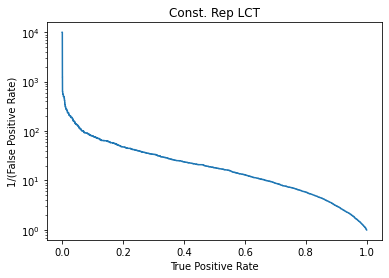

LCT data saved



In [7]:
# set to be the total number of constituents in the event (typically 50 per jet)
num_constits = 100 

lct_train = np.reshape(cropped_train,(cropped_train.shape[0],3*num_constits))
lct_test = np.reshape(cropped_test,(cropped_test.shape[0],3*num_constits))

print("Doing a LCT...")
#lc = LinearRegression()
lc = Ridge(alpha = 1)
lc.fit(lct_train, labels_train)
# make the prediction
predictions = lc.predict(lct_test)
fpr, tpr, _ = roc_curve(labels_test_f, predictions)

auc = roc_auc_score(labels_test_f, predictions)

plt.figure()
plt.plot(tpr, 1.0/fpr)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep LCT")
plt.show()


np.save( expt_dir+"const_rep_lct_fpr"+".npy", fpr )
np.save( expt_dir+"const_rep_lct_tpr"+".npy", tpr )
print("LCT data saved")


Doing a NN...
Starting training...


 16%|█▌        | 190/1200 [01:54<10:10,  1.66it/s]


INFO: Early stopping
Finished Training


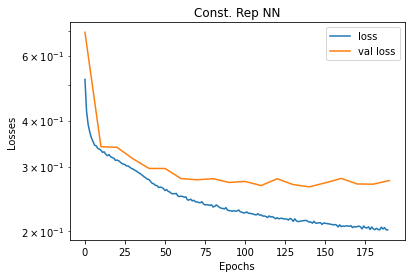

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


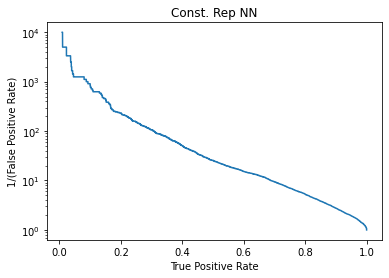

Accuracy of the network: 79 %
ROC AUC: 0.885380445


In [9]:
print("Doing a NN...")
num_epochs_nn = 1200
batch_size_nn = 400
update_epochs_nn = 10
input_shape = 3*num_constits
#update_epochs_nn = 20
lr_nn = 0.001


performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                         cropped_train, labels_train, 
                      cropped_val, labels_val,
                      cropped_test, labels_test_f, True)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats_nn["epochs"],performance_stats_nn["losses"], label = "loss")
plt.plot(performance_stats_nn["val_epochs"],performance_stats_nn["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.title("Const. Rep NN")
plt.show()

plt.figure()
plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.title("Const. Rep NN")
plt.show()

np.save( expt_dir+"const_rep_nn_tpr"+".npy", performance_stats_nn["tpr"] )
np.save( expt_dir+"const_rep_nn_fpr"+".npy", performance_stats_nn["fpr"] )

print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
print("ROC AUC:", performance_stats_nn["auc"])

